# WAVELET ANALYSIS
---

In [1]:
#Numpy
import numpy as np

# Wavelet.
from waveletFunctions import wave_signif, wavelet

#Matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec
from matplotlib.colors import LogNorm
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

#Scipy
from scipy.stats import norm
import scipy.io.idl as idl
from scipy.ndimage import uniform_filter1d

#Extra
import os
import warnings
warnings.filterwarnings('ignore')

In [2]:
def detrend(f, t):
    """ Detrend function
    
    We write the following code to detrend and normalize the input data by its standard deviation. 
    Sometimes detrending is not necessary and simply removing the mean value is good enough. 
    However, if your dataset has a well defined trend, it is strongly advised to perform detrending. 
    Here, we fit a one-degree polynomial function and then subtract it from the original data.
    
    """
    try:
        p    = np.polyfit(t - t[0], f, 1)             # One-degree polynomial
        yfit = f - np.polyval(p, t - t[0])  # Substract the fit from the original data
    except:
        print("It was not possible to fit the function. No detrend applied.")
        dat_notrend = f
    
    return dat_notrend

In [3]:
def cont_wavelet(time, sst, 
                 do_detrend=False, do_substractmean=False, do_normalization=False):
    """ Calculate the continuos wavelet of a signal using MORLET as mother.
    It is possible to detrend the function if it has a clear linear tendency (by default False).
    It is possible to substract the mean of the signal (by default False).
    It is possible to normalize the signal by its standard deviation (by default False).
    
    We can choose between the slow method using the functions from:
        from waveletFunctions import wave_signif, wavelet
    or a faster approach using the pycwt module. They provide the same results.
    
    Inputs: sst (signal), time
    - dj (Sub-octaves per octaves)
    - s0 (Starting scale)
    - j1  (Powers of two with dj sub-octaves)
    - lag1 (Lag-1 autocorrelation for red noise)
    
    Outputs: [power, period, sig95, coi, global_ws]
    
    """
    # -------------------------------------------------------------------------------------------
    # Basic parameters:
    mother = 'MORLET'
    n      = len(sst)       
    deltat = np.diff(time)[0]  
    pad    = 1
    dj     = 1/16.         
    s0     = 2*deltat
    j1     = 8/dj
    lag1   = 0.72
    
    # -------------------------------------------------------------------------------------------
    # We detrend the signal if necessary
    if do_detrend:
        sst = detrend(sst, time) 
    # We substract the mean if necessary
    if do_substractmean:
        sst = sst - np.mean(sst)
    # We compute the standard deviation and the variance    
    std = np.std(sst, ddof=1)
    variance = std ** 2
    # We normalize by standard deviation if necessary
    if do_normalization:
        sst = sst / std
        
    # -------------------------------------------------------------------------------------------  
    wave, period, scale, coi = wavelet(sst, deltat, pad, dj, s0, j1, mother)
        
    # -------------------------------------------------------------------------------------------
    # Power, global wavelet spectrum, and global wavelet spectrum only in COI
    power     = (np.abs(wave)) ** 2            # Compute wavelet power spectrum
    global_ws = (np.sum(power, axis=1) / n)    # Time-average over all times  
    power_coi = np.zeros_like(power)
    for ii in range(len(period)):
        for jj in range(n):
            if period[ii] <= coi[jj]:
                power_coi[ii,jj] = power[ii,jj]
    global_wscoi = (np.sum(power_coi, axis=1) / n)    

    # Significance levels:
    signif = wave_signif(([variance]), dt=deltat, sigtest=0, scale=scale, lag1=lag1, mother=mother)
    sig95  = signif[:, np.newaxis].dot(np.ones(n)[np.newaxis, :])
    sig95  = power / sig95                      # Where ratio is > 1 power is significant


        
        
    # -------------------------------------------------------------------------------------------  
    return power, period, sig95, coi, global_ws, global_wscoi

In [4]:
def plot_cont_wavelet(time, sst, power, periods, sig_slevel, coi, global_ws, global_wscoi):
    """Makes the wavelet plot 

    """
    fig  = plt.figure(figsize=(16, 8),facecolor='w')
    spec = gridspec.GridSpec(ncols=2, nrows=2, figure=fig,hspace=0.6, wspace=0.3)
    


    """PANEL SIGNAL"""
    axes0 = fig.add_subplot(spec[0, 0])
    axes0.plot(time,sst,'-k')
    axes0.set_ylabel(r"u$_z$ [km s$^{-1}$]")
    axes0.tick_params(axis='both', which='major')
    axes0.xaxis.set_minor_locator(AutoMinorLocator())
    axes0.axhline(y=0,linestyle='--',color='r')
    axes0.set_xlabel(r't [min]')


    """PANEL WAVELET"""    
    axes1 = fig.add_subplot(spec[1, 0],sharex=axes0)
    CS0   = axes1.pcolormesh(time, periods, power, cmap="Reds")
    
    # 95# significance contour, levels at -99 (fake) and 1 (95# signif)
    axes1.contour(time, periods, sig_slevel, [-99, 1], colors=['k'])

    # cone-of-influence, anything "below" is dubious
    axes1.plot(time, coi, '--k',lw=3)
    axes1.fill_between(time, coi * 0 + periods[-1], coi, facecolor="none",edgecolor="#00000040", hatch='x')
    
    # format y-scale
    axes1.set_yscale('log', base=2, subs=None)
    axes1.set_ylim([np.min(periods), np.max(periods)])
    axes1.yaxis.set_major_formatter(ticker.ScalarFormatter())
    axes1.yaxis.set_minor_locator(AutoMinorLocator())
    axes1.ticklabel_format(axis='y', style='plain')
    axes1.invert_yaxis()
    axes1.axhline(y=3,linestyle='--',color='k')
    axes1.axhline(y=5,linestyle='dotted',color='k')
    axes1.set_xlim(max(time.min(), time.min()), min(time.max(), time.max()))
    axes1.tick_params(axis='both', which='major')
    axes1.set_ylabel(r'Period [min]')
    axes1.set_xlabel(r't [min]')
    
    p0    = axes1.get_position().get_points().flatten()
    cax   = fig.add_axes([p0[0], p0[3]+0.01, p0[2]-p0[0], 0.010])
    g     = fig.colorbar(CS0, cax=cax, orientation="horizontal")
    g.set_label(r'Power [km$^2$ s$^{-2}$]',labelpad=10)
    g.ax.xaxis.set_ticks_position("top")
    g.ax.xaxis.set_label_position("top")


    
    """PANEL GLOBAL SPECTRUM"""
    axes2 = fig.add_subplot(spec[1, 1], sharey=axes1)
    axes2.plot(global_ws, periods, color='r',linestyle='dotted')
    axes2.plot(global_wscoi, periods, color='k')
    axes2.set_ylim([np.min(periods), np.max(coi)])
    axes2.invert_yaxis()
    axes2.axhline(y=1.5,linestyle='--',color='k')
    axes2.axhline(y=3,linestyle='--',color='k')
    axes2.axhline(y=5,linestyle='dotted',color='k')
    axes2.set_title("Global wavelet spectrum")
    axes2.set_xlabel(r'Power [km$^2$ s$^{-2}$]')
    axes2.tick_params(axis='both', which='major')
    
    plt.savefig("/Users/desiveri/Desktop/example.png",dpi=300,bbox_inches='tight')
    
    plt.show()

## Input data

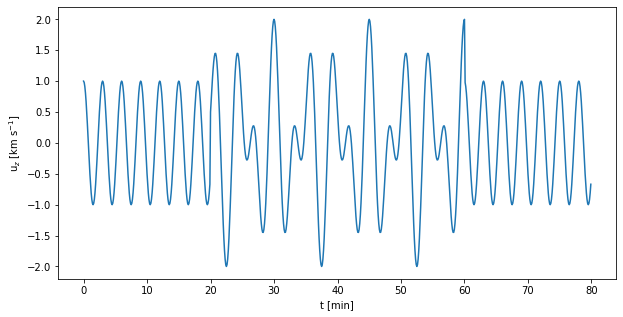

In [5]:
# Time in minutes
t0 = 0 
tf = 80
dt = 1/10.
tt = np.arange(t0,tf,dt)
nt = len(tt)
# Cos functions with frecuencies in min-1. Second function only valid in a given time range:
freq1 = 1/3.
tlim0 = 20
tlimf = 60
freq2 = 1/5.
func1 = np.cos(2*np.pi*freq1*tt)
func2 = np.cos(2*np.pi*freq2*tt)
func2[:np.where(tt<tlim0)[0][-1]+1] = 0
func2[np.where(tt>=tlimf)[0][0]+1:] = 0


# Noise
noise = 0.0*norm.ppf(np.random.rand(nt))
# Final function
func = func1 + func2 + noise

#func = 2*np.arctan(1/np.tan(np.pi * tt* freq2))/ np.pi + noise
# Plot
fig, ax = plt.subplots(1,1,figsize=(10,5))
ax.plot(tt,func)
ax.set_xlabel(r't [min]')
ax.set_ylabel(r"u$_z$ [km s$^{-1}$]")
plt.show()

# You can also try to filtering the signal, to remove noise, e.g
#func  = uniform_filter1d(func, size=int(1/dt))

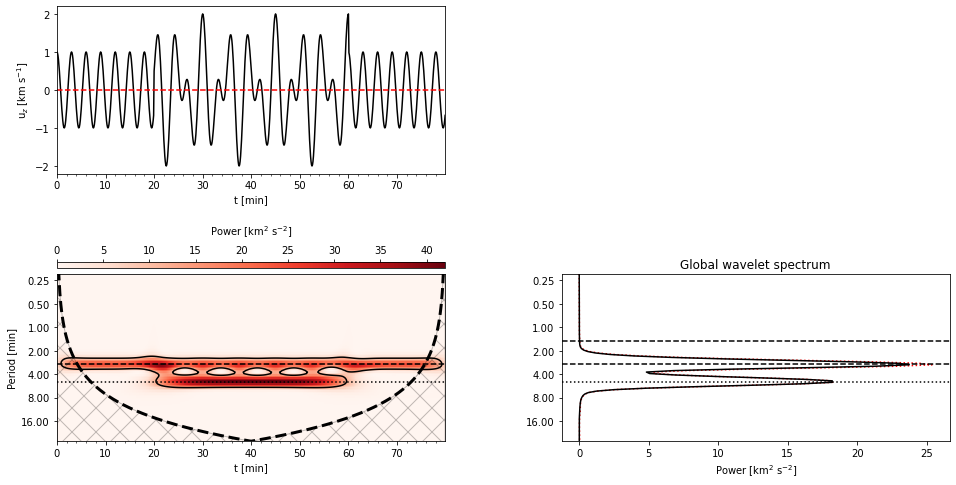

In [6]:
power, periods, sig95, coi, global_ws, global_wscoi = cont_wavelet(tt, func)
plot_cont_wavelet(tt, func, power, periods, sig95, coi, global_ws, global_wscoi)